In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import natsort
import warnings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
warnings.filterwarnings('ignore')

In [2]:
# Define constants
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
PIXELS = IMAGE_HEIGHT * IMAGE_WIDTH*3

In [4]:
di1 = "./graduation_dataset/final_data/5. mask_sun_vs_glasses/train/"

filenames = os.listdir(di1)

categories = []

for filename in filenames:
    category = filename.split('_')[0]
    if category == 'glasses':
        categories.append(0)
    else :
        categories.append(1)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df.head()

,filename,category
0,glasses_000.png,0
1,glasses_001.png,0
2,glasses_002.png,0
3,glasses_003.png,0
4,glasses_004.png,0


In [5]:
df.tail()

,filename,category
296,sunglasses_129.jpg,1
297,sunglasses_130.jpg,1
298,sunglasses_131.jpg,1
299,sunglasses_132.jpg,1
300,sunglasses_133.jpg,1


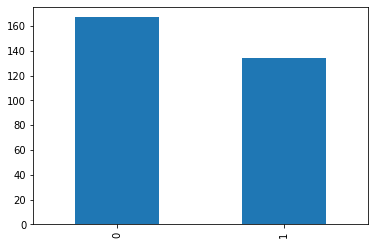

In [6]:
df['category'].value_counts().plot.bar()

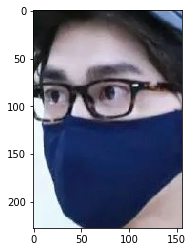

In [7]:
# See sample image
sample = random.choice(filenames)
image = load_img(di1+sample)
plt.imshow(image)

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128,kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adamax', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [9]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [10]:
# Early Stop
earlystop = EarlyStopping(patience=10)

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [12]:
callbacks= [earlystop, learning_rate_reduction]

In [13]:
df["category"] = df["category"].replace({0: 'glasses', 1: 'sunglasses'})

In [14]:
df.head()

,filename,category
0,glasses_000.png,glasses
1,glasses_001.png,glasses
2,glasses_002.png,glasses
3,glasses_003.png,glasses
4,glasses_004.png,glasses


In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

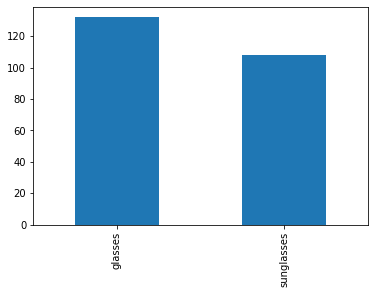

In [16]:
train_df['category'].value_counts().plot.bar()

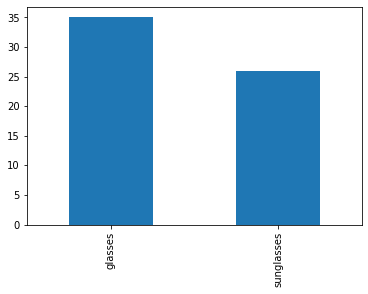

In [17]:
validate_df['category'].value_counts().plot.bar()

In [18]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [19]:
#Train Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
     train_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)

Found 240 validated image filenames belonging to 2 classes.


In [20]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size = batch_size
)


Found 61 validated image filenames belonging to 2 classes.


In [21]:
#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    di1,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
)

Found 1 validated image filenames belonging to 1 classes.


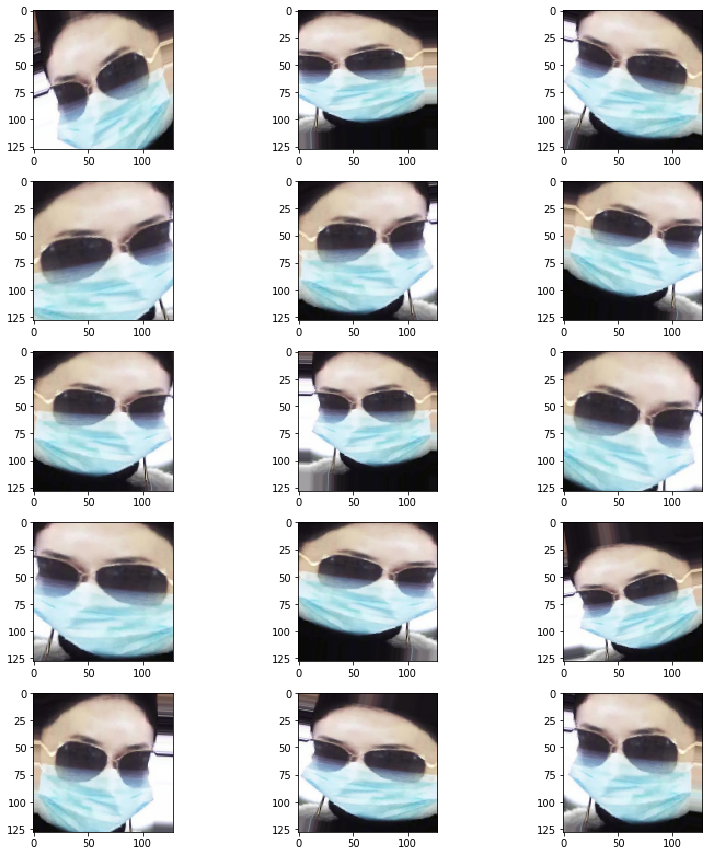

In [22]:
plt.figure(figsize=(12,12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break

plt.tight_layout()
plt.show()

In [23]:
# Fit model
epochs = 3 if FAST_RUN else 50

history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data= validation_generator,
    validation_steps= total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    #callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
16/16 [==============================] - 9s 544ms/step - loss: 1.1772 - accuracy: 0.4917 - val_loss: 0.6918 - val_accuracy: 0.5500
Epoch 2/50
16/16 [==============================] - 7s 454ms/step - loss: 0.7126 - accuracy: 0.5125 - val_loss: 0.6927 - val_accuracy: 0.5833
Epoch 3/50
16/16 [==============================] - 7s 451ms/step - loss: 0.6835 - accuracy: 0.5667 - val_loss: 0.6923 - val_accuracy: 0.5667
Epoch 4/50
16/16 [==============================] - 8s 485ms/step - loss: 0.6818 - accuracy: 0.5833 - val_loss: 0.6915 - val_accuracy: 0.5667
Epoch 5/50
16/16 [==============================] - 8s 495ms/step - loss: 0.6678 - accuracy: 0.5875 - val_loss: 0.6866 - val_accuracy: 0.5833
Epoch 6/50
16/16 [==============================] - 9s 535ms/step - loss: 0.6657 - accuracy: 0.5917 - val_loss: 0.6818 - val_accuracy: 0.5833
Epoch 7/50
16/16 [==============================] - 8s 519ms/step - loss

In [24]:
model.save_weights("mask_sunglasses_model_final.h5")

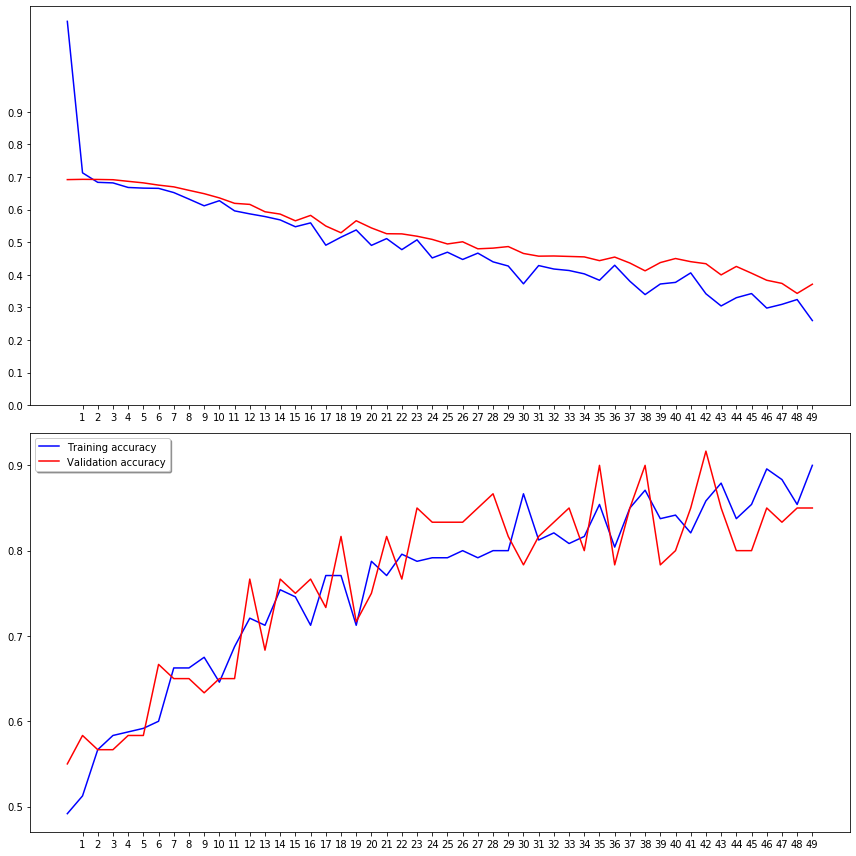

In [25]:
# Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r', label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [78]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (128, 128, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [82]:
di2 = './graduation_dataset/glasses/test_3/'
di2 = './graduation_dataset/glasses/0_glasses/'
## /graduation_dataset/glasses/3_round/round_140.png'
## graduation_dataset/glasses/0_glasses/glasses_006.png
## graduation_dataset/glasses/3_round/round_172.png
# img = plt.imread(filepath)
# plt.imshow(img)
# image = load(filepath)
# result_1 = model.predict(image)
filenames = os.listdir(di2)

for filename in filenames:
    filepath = di2 + filename
    img = plt.imread(filepath)
    image = load(filepath)
    result_1 = model.predict(image)
    print('예측: '+ filename)

    if max(result_1[0]) == result_1[0][0]:
         print('해당 사진은 안경을 썼습니다.')
    else:
         print('해당 사진은 선글라스를 썼습니다.')

    print(max(result_1[0]))
    print(result_1)

예측: glasses_000.png
해당 사진은 안경을 썼습니다.
0.9369703
[[0.9369703  0.05509257]]
예측: glasses_001.png
해당 사진은 안경을 썼습니다.
0.8533946
[[0.8533946  0.13805719]]
예측: glasses_002.png
해당 사진은 안경을 썼습니다.
0.9571888
[[0.9571888  0.03405219]]
예측: glasses_003.png
해당 사진은 안경을 썼습니다.
0.9619832
[[0.9619832  0.03425882]]
예측: glasses_004.png
해당 사진은 안경을 썼습니다.
0.9447237
[[0.9447237  0.04675084]]
예측: glasses_005.png
해당 사진은 안경을 썼습니다.
0.9425487
[[0.9425487  0.05156319]]
예측: glasses_006.png
해당 사진은 안경을 썼습니다.
0.90953475
[[0.90953475 0.08387456]]
예측: glasses_007.png
해당 사진은 안경을 썼습니다.
0.9337795
[[0.9337795 0.058981 ]]
예측: glasses_008.png
해당 사진은 안경을 썼습니다.
0.94171005
[[0.94171005 0.05173875]]
예측: glasses_009.png
해당 사진은 안경을 썼습니다.
0.9425813
[[0.9425813  0.05037323]]
예측: glasses_010.png
해당 사진은 안경을 썼습니다.
0.9738376
[[0.9738376  0.02241054]]
예측: glasses_011.png
해당 사진은 안경을 썼습니다.
0.91751677
[[0.91751677 0.07381006]]
예측: glasses_012.png
해당 사진은 안경을 썼습니다.
0.92638093
[[0.92638093 0.06799185]]
예측: glasses_013.png
해당 사진은 안경을 썼습니다.
0.9308183
[[

예측: glasses_112.png
해당 사진은 안경을 썼습니다.
0.8986535
[[0.8986535 0.0915295]]
예측: glasses_113.png
해당 사진은 안경을 썼습니다.
0.82369864
[[0.82369864 0.1638615 ]]
예측: glasses_114.png
해당 사진은 안경을 썼습니다.
0.9504598
[[0.9504598  0.04520022]]
예측: glasses_115.png
해당 사진은 안경을 썼습니다.
0.944335
[[0.944335   0.05034652]]
예측: glasses_116.png
해당 사진은 안경을 썼습니다.
0.9010451
[[0.9010451  0.08902203]]
예측: glasses_117.png
해당 사진은 안경을 썼습니다.
0.7572858
[[0.7572858 0.2352054]]
예측: glasses_118.png
해당 사진은 안경을 썼습니다.
0.9361876
[[0.9361876  0.05261132]]
예측: glasses_119.png
해당 사진은 안경을 썼습니다.
0.9271005
[[0.9271005 0.0670835]]
예측: glasses_120.png
해당 사진은 안경을 썼습니다.
0.95904166
[[0.95904166 0.03612095]]
예측: glasses_121.png
해당 사진은 안경을 썼습니다.
0.9197356
[[0.9197356  0.06805347]]
예측: glasses_122.png
해당 사진은 안경을 썼습니다.
0.9517721
[[0.9517721  0.04159441]]
예측: glasses_123.png
해당 사진은 안경을 썼습니다.
0.88193107
[[0.88193107 0.1056563 ]]
예측: glasses_124.png
해당 사진은 안경을 썼습니다.
0.9581999
[[0.9581999  0.03515039]]
예측: glasses_125.png
해당 사진은 안경을 썼습니다.
0.957764
[[0.95776